In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df=pd.read_csv('iiot_30min_norm.csv')
df.head()

,TIME,FM1,PE1,PE2,PE3,PE4,TP1,TP2,EPOCH
0,2020-07-05 21:00:00+00:00,0.291841,0.944212,0.969845,0.909817,0.752879,0.128703,0.729592,1593982800
1,2020-07-05 21:30:00+00:00,0.290384,0.947971,0.971459,0.913576,0.753741,0.117572,0.723905,1593984600
2,2020-07-05 22:00:00+00:00,0.279458,0.944138,0.968994,0.912516,0.753187,0.111242,0.720671,1593986400
3,2020-07-05 22:30:00+00:00,0.288927,0.950337,0.976253,0.915991,0.756699,0.102464,0.716186,1593988200
4,2020-07-05 23:00:00+00:00,0.299610,0.950226,0.975747,0.916188,0.756563,0.093201,0.711454,1593990000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TIME    720 non-null    object 
 1   FM1     720 non-null    float64
 2   PE1     720 non-null    float64
 3   PE2     720 non-null    float64
 4   PE3     720 non-null    float64
 5   PE4     720 non-null    float64
 6   TP1     720 non-null    float64
 7   TP2     720 non-null    float64
 8   EPOCH   720 non-null    int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 50.8+ KB


In [124]:
df['Date'] = pd.to_datetime(df['TIME'])
df.drop('TIME', axis=1, inplace=True)

In [125]:
df.isnull().sum()

FM1      0
PE1      0
PE2      0
PE3      0
PE4      0
TP1      0
TP2      0
EPOCH    0
Date     0
dtype: int64

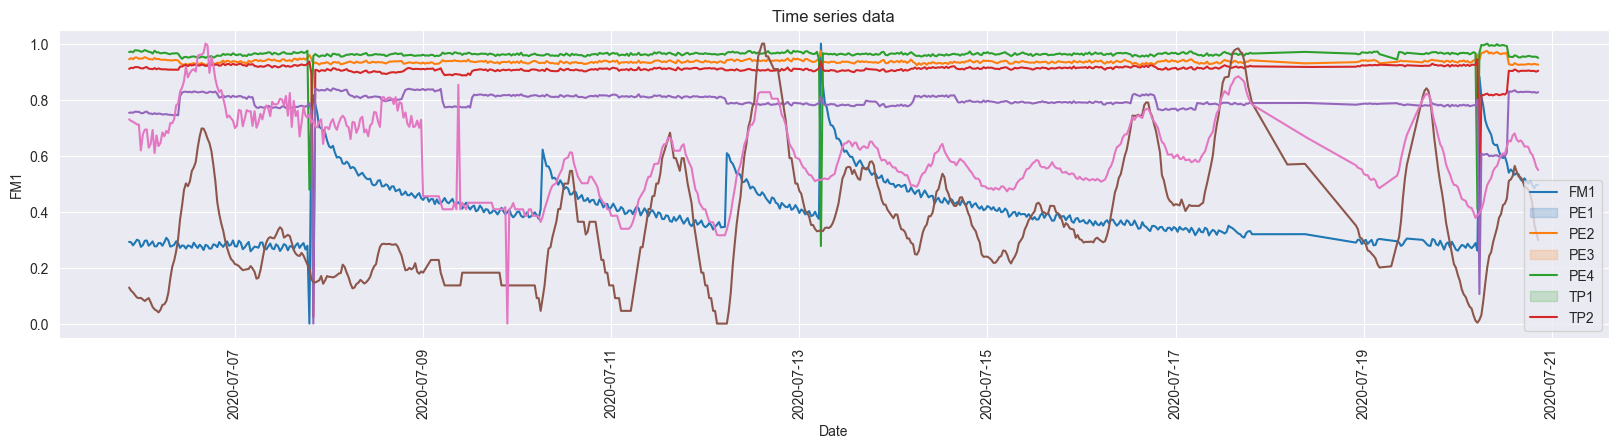

In [126]:
var=['FM1','PE1','PE2','PE3','PE4','TP1','TP2']
plt.figure(figsize=(20,4))
for column in var:
        sns.lineplot(x='Date', y=column, data=df)
plt.xticks(rotation=90)
plt.title('Time series data')
plt.legend(var)
plt.show()

<Axes: >

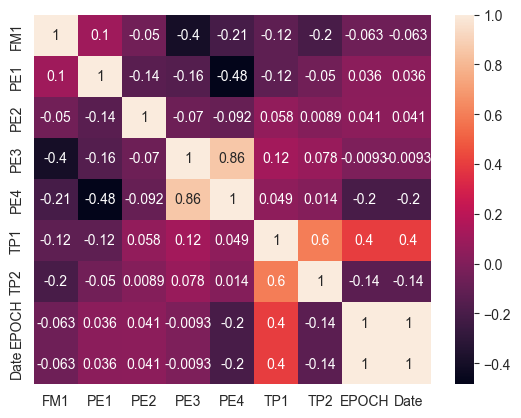

In [127]:
sns.heatmap(df.corr(), annot=True)

In [129]:
X = df.drop(columns=['Date', 'FM1'])
y = df['FM1']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
y=df['FM1']

In [130]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
# Define regression models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'ExtraTrees': ExtraTreesRegressor(),
    'XGBoost': XGBRegressor(),
    'MLPRegressor': MLPRegressor(max_iter=100),
    'LassoRegression': Lasso(),
    'ElasticNetRegression': ElasticNet()
}

In [ ]:
# Define hyperparameters for tuning
params = {
    'Linear Regression': {},
    'Decision Tree': {'max_depth': [5, 10, 15]},
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'SVR': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 10]},
    'ExtraTrees': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 6, 9]},
    'MLPRegressor': {'hidden_layer_sizes': [(64,), (128, 64), (128, 64, 32)], 'activation': ['relu', 'tanh']},
    'LassoRegression': {'alpha': [0.01, 0.1, 1]},
    'ElasticNetRegression': {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.2, 0.5, 0.8]}
}

In [131]:
best_models = {}
scores = []

best_score = float("-inf")  # Initialize worst possible score
best_model_name = ''
best_model = None

for model_name in models.keys():
    print(f"Training {model_name}...")

    grid = GridSearchCV(models[model_name], params[model_name], cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    best_models[model_name] = grid.best_estimator_
    y_pred = grid.best_estimator_.predict(X_test)

    # Use R² Score for regressors
    score = r2_score(y_test, y_pred)
    scores.append([model_name, score, grid.best_params_])

    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Score for {model_name}: {score}")

    # Select the best model based on highest R² score
    if score > best_score:
        best_score = score
        best_model_name = model_name
        best_model = grid.best_estimator_

# Display scores in a table format
print("\nModel Performance Summary:")
print(tabulate(scores, headers=["Model", "R² Score", "Best Parameters"], tablefmt="grid"))

print(f"\nBest regression model: {best_model_name} with R² score: {best_score:.4f} by utilizing best parameters: {best_models[best_model_name]}")

Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Linear Regression: {}
Score for Linear Regression: 0.33269948433229746
Training Decision Tree...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for Decision Tree: {'max_depth': 15}
Score for Decision Tree: 0.7569034235395212
Training RandomForest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for RandomForest: {'max_depth': 20, 'n_estimators': 100}
Score for RandomForest: 0.8785398607940442
Training GradientBoosting...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 200}
Score for GradientBoosting: 0.8750108780144327
Training SVR...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for SVR: {'C': 10}
Score for SVR: 0.5191689381602391
Training KNN...
Fitting 5 folds for each of 3 candidates, totalling 15 fi

In [ ]:
# Predictions using XGBoost model
y_pred = best_models['XGBoost'].predict(X_test)
residuals = y_test - y_pred

In [ ]:

# Calculate MAE and MSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("\nModel Performance Summary:")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

In [ ]:

# 1️⃣ Actual vs. Predicted Values Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal 45-degree line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (XGBoost Regressor)")
plt.show()

In [ ]:

# 2️⃣ Feature Importance Plot
X_train = pd.DataFrame(X_train, columns=X.columns)
feature_importances = best_models['XGBoost'].feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for XGBoost Regressor")
plt.show()


Model Performance Summary:
R2 Score: 0.9126
Mean Absolute Error (MAE): 0.0176
Mean Squared Error (MSE): 0.0009


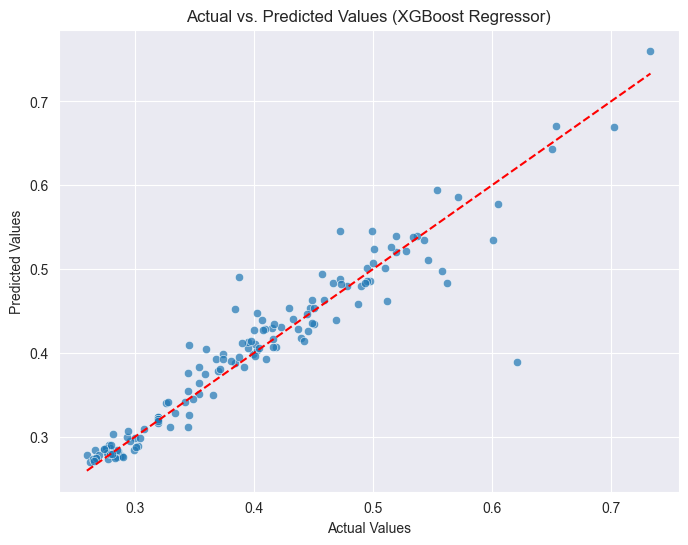

C:\Users\LexusYj\AppData\Local\Temp\ipykernel_28680\1542433027.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="viridis")


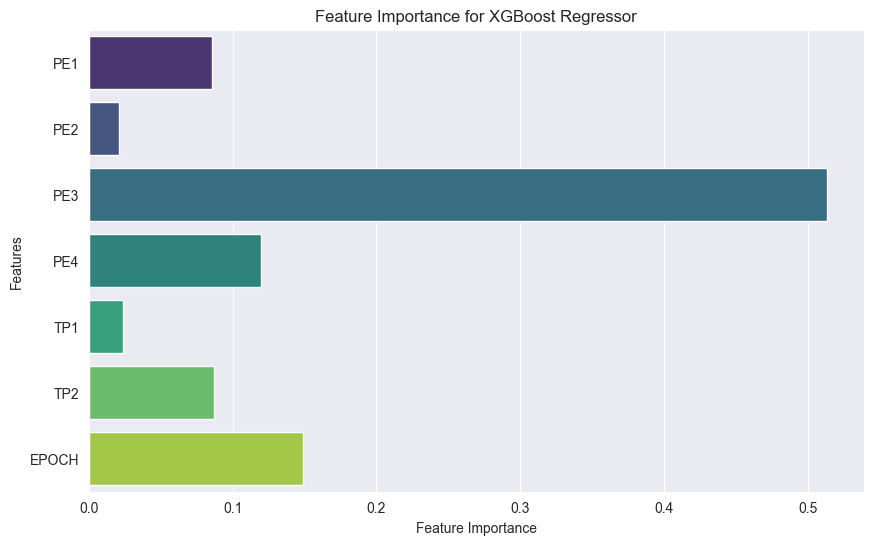

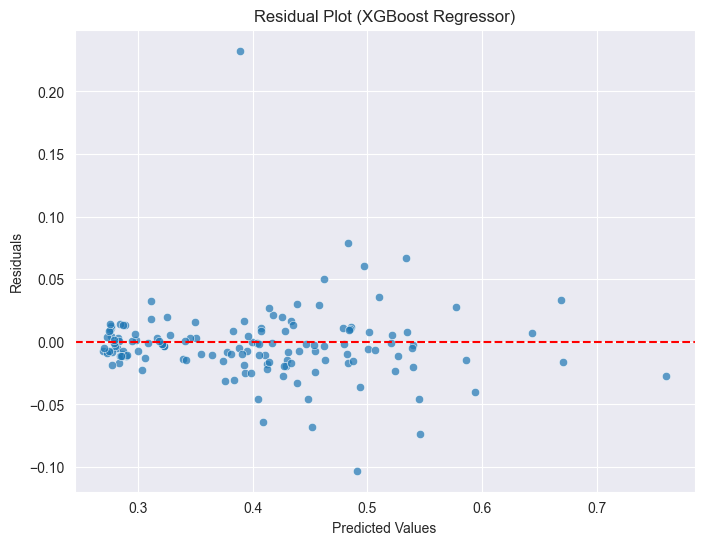

In [134]:

# 3️⃣ Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')  # Zero residual line
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (XGBoost Regressor)")
plt.show()